In [1]:
import os
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import torch

# Configure Polars 
cfg = pl.Config()
cfg.set_tbl_rows(2000)

/Users/anders/Desktop/learning/internet-movie-script-dataset/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


polars.config.Config

In [2]:
# pandas would also work
# polars has more strict data types
df = pl.read_excel('data/in/The Internet Movie Script Dataset .xlsx')
df.head()

Sr.No,Movie,Writers,Genre,Date,Sript
i64,str,str,str,str,str
1,"""9""","""Pamela Pettler,Shane Acker""","""Animation,Adventure,Drama,Fant…","""September_2009""",""",SEQ.,05,-,PROLOGUE ,,,,, ,,…"
2,"""A Scanner Darkly""","""Charlie Kaufman""","""Animation,Crime,Drama""","""July_2006""","""SHOT,OF,NOTEBOOK,PAGE,DAPPLED,…"
3,"""Aladdin""","""Roger Allers,Ron Clements""","""Animation,Family,Musical,Fanta…","""December_1992""","""PEDDLER:,,Oh,I,come,from,a,lan…"
4,"""Anastasia ""","""Susan Gauthier,Bruce Graham""","""Family,Animation,Musical""","""December_1997""","""FADE,IN: on,a,well-worn,PHO…"
5,"""Antz ""","""Todd Alcott,Chris Weitz,Paul W…","""Adventure,Animation,Comedy,Fan…",null,"""Z,(O.S.) ,,,,,,,,,,,(over,a,d…"


# Cleaning the Data

There were a few issues with the data that needed remedying

1. The comma character is used in lieu of a space character for some scripts
2. There is one near duplicate that needs to be consolidated
3. Mispelled column name
4. Dates are written out in odd format

Fix mispelled column name. Notice there is one more row than unique movie title, is it the same movie?

In [3]:
df = df.rename({"Sript": "script"})
print(df.shape)
print(df["Movie"].n_unique())

(60, 6)
59


Looks like it's definitely the same movie

In [4]:
dupd = df.filter(df["Movie"].is_duplicated())
dupd

Sr.No,Movie,Writers,Genre,Date,script
i64,str,str,str,str,str
28,"""Nightmare Before Christmas The""","""Tim Burton,Michael McDowell""","""Animation,Comedy,Fantasy,Horro…","""August_1991""","""NARRATOR 'Twas a long time ag…"
29,"""Nightmare Before Christmas The""","""Caroline Thompson""","""Animation,Comedy,Fantasy,Horro…","""August_1991""","""NARRATOR 'Twas a long time ag…"


Same script & genre

In [5]:
dupd["script"][0] == dupd["script"][1]

True

In [6]:
dupd["Genre"][0] == dupd["Genre"][1]

True

Add the writers together to preserve information, as that is the only difference

In [7]:
# edit the writers field for this record
df[27, "Writers"] = df[27, "Writers"] + ',' + df[28, "Writers"]
# drop the record
df = df.filter(
    pl.col("Sr.No")!=29
)
# ensure uniqueness
print(df.shape)
print(df["Movie"].n_unique())

(59, 6)
59


**Commas instead of space characters**

In [8]:
print(df[0, "script"][:350])

,SEQ.,05,-,PROLOGUE
,,,,,
,,,,,,The,Focus,Features,logo,appears,on,screen,and,we,slide,INTO
,,,,,the,"O",in,Focus.
,,,,,
,,,,,Stock,dissolves,from,35mm,to,16mm.,,,,BLACK,&,WHITE.,,GRAINY,
,,,,,like,OLD,DOCUMENTARY,FOOTAGE.
,,,,,
,,,,,,,,,,,,,,,,,SCIENTIST'S,VOICE
,,,,,,,,,,,,Experiment,208,day,20...
,,,,,
,,,,,
,,,,,INT.,SCIENTIST'S,LAB


<Axes: xlabel='fraction_commas', ylabel='Count'>

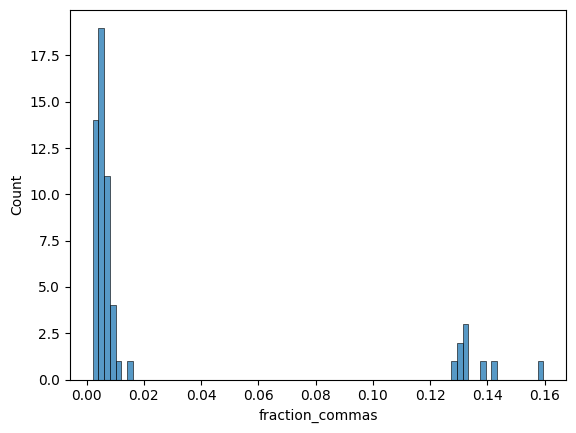

In [9]:
df = df.with_columns(
    comma_count = pl.col("script").str.count_matches(r'[,]+'), # count the number of commas
    script_length = pl.col("script").str.len_chars() # count the length of the script
).with_columns(
    fraction_commas = pl.col("comma_count")/pl.col("script_length") # what % of the script is commas?
)

sns.histplot(
    df,
    x="fraction_commas"
)

So it looks like the outliers on the right must be all scripts with commas instead of space characters. For those scripts only, let's replace the commas with a space

In [10]:

df = df.with_columns(
    script_clean = pl.when( # when the fraction of commas is too high
        pl.col("fraction_commas") > 0.1
    ).then( # replace all instances of a comma with a space
        pl.col("script").str.replace_all(r'[,]+', " ")
    ).otherwise(pl.col("script")) # otherwise keep original script
)

In [11]:
# looks better to me!
print(df[0, "script_clean"][:350])

 SEQ. 05 - PROLOGUE
 
 The Focus Features logo appears on screen and we slide INTO
 the "O" in Focus.
 
 Stock dissolves from 35mm to 16mm. BLACK & WHITE. GRAINY 
 like OLD DOCUMENTARY FOOTAGE.
 
 SCIENTIST'S VOICE
 Experiment 208 day 20...
 
 
 INT. SCIENTIST'S LAB - DAY

 We see an early incarnation of a MACHINE (this will be the
 


**Cleaning Dates**

In [12]:
df['Date'].sample(5, seed=1)

Date
str
"""June_2008"""
"""December_1992"""
"""December_2012"""
"""August_1991"""
"""2007-08-01 00:00:00"""


**There are two date formats**

1. `%B_%Y` for month name underscore year number
2. `%Y-%m-%d %H:%M:%S` for year number dash month number dash day number dash time

There are also null values

There is a leading space for the date of one movie (Alien 3)

*We can differentiate the date format by the presence of an underscore, and use different logic to parse the two types of dates*

In [13]:
df = df.with_columns(
    pl.when(
        pl.col("Date").str.contains('_', literal=True)
    ) # when there is an underscore
    .then( # it is the first format
        (
            # Alien 3 date had a leading space
            pl.col("Date").str.replace_all("\\s", "") + 
            pl.lit("_01")
        ) # add the day number (required for date datatype in polars)
        .str.to_date( # convert to date
            "%B_%Y_%d",
            strict=False,
            exact=True
    ))
    .otherwise( # second format
        pl.col("Date").str.to_datetime(
            "%Y-%m-%d %H:%M:%S", # convert to datetime
            strict=False,
            exact=True
        )
        .cast(pl.Date) # then back to date
    )
    .alias("date_clean") # name the new column
)

print("Check if we accidentally nullified any dates")
df.filter(
    pl.col("Date").is_not_null() & pl.col("date_clean").is_null()
).select(pl.col("Movie", "Date", "date_clean"))

Check if we accidentally nullified any dates


Movie,Date,date_clean
str,str,date


### Rename columns and send to parquet

In [14]:
df.head(1)

Sr.No,Movie,Writers,Genre,Date,script,comma_count,script_length,fraction_commas,script_clean,date_clean
i64,str,str,str,str,str,u32,u32,f64,str,date
1,"""9""","""Pamela Pettler,Shane Acker""","""Animation,Adventure,Drama,Fant…","""September_2009""",""",SEQ.,05,-,PROLOGUE ,,,,, ,,…",3667,26466,0.138555,""" SEQ. 05 - PROLOGUE The F…",2009-09-01


In [15]:
df = df.rename(
    {
        "Date": "date_original",
        "script": "script_original",
    },
    strict=False
).rename(
    {
        "script_clean": "script",
        "date_clean": "date"
    },
    strict=False
)
df.columns = pl.Series(df.columns).str.to_lowercase()
df.write_parquet(
    "data/out/internet-movie-script.parquet"
)

# Genre Counts

In [18]:
df["genre"].str.replace_all(r'[\s]', '')\
    .str.replace_all(r'[,]+', ',')\
    .str.split(",").explode().value_counts()\
    .sort(pl.col("count"), descending=True)

genre,count
str,u32
"""Animation""",41
"""Adventure""",35
"""Comedy""",31
"""Action""",24
"""Family""",20
"""Drama""",15
"""Fantasy""",14
"""Thriller""",13
"""Sci-Fi""",10
